# EI Progression

## Setup

In [3]:
import pandas
import sklearn
import scipy
from sklearn import model_selection, linear_model, preprocessing, metrics, ensemble
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy import cluster
from scipy.cluster import hierarchy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [53]:
def shap_value_effect(feature, nb, shap_values):
    """
    returns the influence of the feature on the prediction of a specific data point
    feature = name of the feature we are looking at
    nb = index of the point
    """
    print(f'The SHAP value of {feature} for the experiment number {nb} was {shap_values.values[nb][x_train.columns.to_list().index(feature)]}.')
    if shap_values.values[nb][x_train.columns.to_list().index(feature)] > 0:
        if shap_values.data[nb][x_train.columns.to_list().index(feature)] == 1:
            print(f"The use of {feature} in this experiment made the yield higher than average.")
        else:
            print(f'The lack of {feature} in this experiment made the yield higher than average.')
    else:
        if shap_values.data[nb][x_train.columns.to_list().index(feature)] == 1:
            print(f"The use of {feature} in this experiment made the yield lower than average.")
        else:
            print(f'The lack of {feature} in this experiment made the yield lower than average.')
    #print(f'Average yield = {shap_values.base_values[nb]}')
    print(f'Predicted yield of this experiment = {y_pred[nb]}')
    print(f'Actual yield of this experiment = {y_temp["Yield of 3aa"][nb]}')

def shap_global(feature, shap_values):
    """
    returns the global effect of a feature on the yield by analyzing its SHAP values
    """
    feature_shaps_pos = [shap_values.values[i][x_train.columns.to_list().index(feature)] for i in range(0,len(shap_values.values)) if shap_values.data[i][x_train.columns.to_list().index(feature)] == 1]
    feature_shaps_neg = [shap_values.values[i][x_train.columns.to_list().index(feature)] for i in range(0,len(shap_values.values)) if shap_values.data[i][x_train.columns.to_list().index(feature)] == 0]
    pos_mean = np.mean(feature_shaps_pos)
    neg_mean = np.mean(feature_shaps_neg)
    print(f"The mean SHAP value impact on the yield when {feature} is present is", pos_mean)
    print(f"The mean SHAP value impact on the yield when {feature} is absent is", neg_mean)
    if np.abs(pos_mean) > np.abs(neg_mean):
        if pos_mean > 0:
            print(f"Overall, the presence of {feature} makes the yield higher.")
        else:
            print(f'Overall, the presence of {feature} makes the yield lower.')
    else:
        if neg_mean > 0:
            print(f"Overall, the absence of {feature} makes the yield higher.")
        else:
            print(f'Overall, the absence of {feature} makes the yield lower.')

# if both values are the same sign, there could be a problem...This is a very basic analysis

In [7]:
rxns_df_x = pandas.read_csv("godineau2023_reactions_OHE.csv")
rxns_df_x = rxns_df_x.drop('Unnamed: 0', axis=1)
rxns_df_y = pandas.read_csv("godineau2023_yields_OHE.csv")
rxns_df_y = rxns_df_y.drop('Unnamed: 0', axis=1)

In [30]:
rxns_df_x_EI = rxns_df_x.copy()
rxns_df_y_EI = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_EI)):
    if rxns_df_x_EI['EI'][i] != 1:
        rxns_df_x_EI = rxns_df_x_EI.drop([i], axis=0)
        rxns_df_y_EI = rxns_df_y_EI.drop([i], axis=0)
rxns_df_x_EI= rxns_df_x_EI.drop('UCB', axis=1)
rxns_df_x_EI= rxns_df_x_EI.drop('EI', axis=1)
rxns_df_x_EI= rxns_df_x_EI.drop('TS', axis=1)
rxns_df_x_EI1= pandas.DataFrame(rxns_df_x_EI.values.tolist())
rxns_df_x_EI1.columns = rxns_df_x_EI.columns
rxns_df_x_EI = rxns_df_x_EI1

In [47]:
def train_model(x,y):
    model = RandomForestRegressor(random_state=42)
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)
    model.fit(x_train,y_train)
    info_dict = {}
    #validation
    y_val_pred = model.predict(x_val)
    info_dict['predicted yield validation'] = y_val_pred
    #accuracy = model.score(y_val_pred, y_val)
    accuracy = r2_score(y_val, y_val_pred)
    info_dict['validation r2 score'] = accuracy
    MAE_val = mean_absolute_error(y_val, y_val_pred)
    info_dict['validation MAE'] = MAE_val
    RMSE_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    info_dict['validation RMSE'] = RMSE_val
    

    #testing
    y_test_pred = model.predict(x_test)
    info_dict['predicted yield test'] = y_test_pred
    accuracy_test = r2_score(y_test, y_test_pred)
    #accuracy_test = model.score(y_test_pred, y_test)
    info_dict['test r2 score'] = accuracy_test
    MAE_test = mean_absolute_error(y_test, y_test_pred)
    info_dict['test MAE'] = MAE_test
    RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    info_dict['test RMSE'] = RMSE_test

    explainer = shap.Explainer(model, x_train)
    shap_values = explainer(x_test, check_additivity=False)
    
    return info_dict, shap_values

## Training the models

In [52]:
x_00 = rxns_df_x_EI.copy()
x_00 = x_00.iloc[:8]
for i in range(0,11):
    x_00 = x_00.drop(f'Round {i}', axis=1)
y_00 = rxns_df_y_EI.copy()
y_00 = y_00.iloc[:8]
info_00, shap_00 = train_model(x_00,y_00)

x_01 = rxns_df_x_EI.copy()
x_01 = x_01.iloc[:16]
for i in range(0,11):
    x_01 = x_01.drop(f'Round {i}', axis=1)
y_01 = rxns_df_y_EI.copy()
y_01 = y_01.iloc[:16]
info_01, shap_01 = train_model(x_01,y_01)

x_02 = rxns_df_x_EI.copy()
x_02 = x_02.iloc[:24]
for i in range(0,11):
    x_02 = x_02.drop(f'Round {i}', axis=1)
y_02 = rxns_df_y_EI.copy()
y_02 = y_02.iloc[:24]
info_02, shap_02 = train_model(x_02,y_02)

x_03 = rxns_df_x_EI.copy()
x_03 = x_03.iloc[:32]
for i in range(0,11):
    x_03 = x_03.drop(f'Round {i}', axis=1)
y_03 = rxns_df_y_EI.copy()
y_03 = y_03.iloc[:32]
info_03, shap_03 = train_model(x_03,y_03)

x_04 = rxns_df_x_EI.copy()
x_04 = x_04.iloc[:40]
for i in range(0,11):
    x_04 = x_04.drop(f'Round {i}', axis=1)
y_04 = rxns_df_y_EI.copy()
y_04 = y_04.iloc[:40]
info_04, shap_04 = train_model(x_04,y_04)

x_05 = rxns_df_x_EI.copy()
x_05 = x_05.iloc[:48]
for i in range(0,11):
    x_05 = x_05.drop(f'Round {i}', axis=1)
y_05 = rxns_df_y_EI.copy()
y_05 = y_05.iloc[:48]
info_05, shap_05 = train_model(x_05,y_05)

x_06 = rxns_df_x_EI.copy()
x_06 = x_06.iloc[:56]
for i in range(0,11):
    x_06 = x_06.drop(f'Round {i}', axis=1)
y_06 = rxns_df_y_EI.copy()
y_06 = y_06.iloc[:56]
info_06, shap_06 = train_model(x_06,y_06)

x_07 = rxns_df_x_EI.copy()
x_07 = x_07.iloc[:64]
for i in range(0,11):
    x_07 = x_07.drop(f'Round {i}', axis=1)
y_07 = rxns_df_y_EI.copy()
y_07 = y_07.iloc[:64]
info_07, shap_07 = train_model(x_07,y_07)

x_08 = rxns_df_x_EI.copy()
x_08 = x_08.iloc[:72]
for i in range(0,11):
    x_08 = x_08.drop(f'Round {i}', axis=1)
y_08 = rxns_df_y_EI.copy()
y_08 = y_08.iloc[:72]
info_08, shap_08 = train_model(x_08,y_08)

x_09 = rxns_df_x_EI.copy()
x_09 = x_09.iloc[:80]
for i in range(0,11):
    x_09 = x_09.drop(f'Round {i}', axis=1)
y_09 = rxns_df_y_EI.copy()
y_09 = y_09.iloc[:80]
info_09, shap_09 = train_model(x_09,y_09)

x_10 = rxns_df_x_EI.copy()
x_10 = x_10.iloc[:]
for i in range(0,11):
    x_10 = x_10.drop(f'Round {i}', axis=1)
y_10 = rxns_df_y_EI.copy()
y_10 = y_10.iloc[:]
info_10, shap_10 = train_model(x_10,y_10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

Note that the samples are relatively small (maximum 88 data points)

In [54]:
def total_list(feature):
    l = []
    l.append(info_00[feature])
    l.append(info_01[feature])
    l.append(info_02[feature])
    l.append(info_03[feature])
    l.append(info_04[feature])
    l.append(info_05[feature])
    l.append(info_06[feature])
    l.append(info_07[feature])
    l.append(info_08[feature])
    l.append(info_09[feature])
    l.append(info_10[feature])
    return l

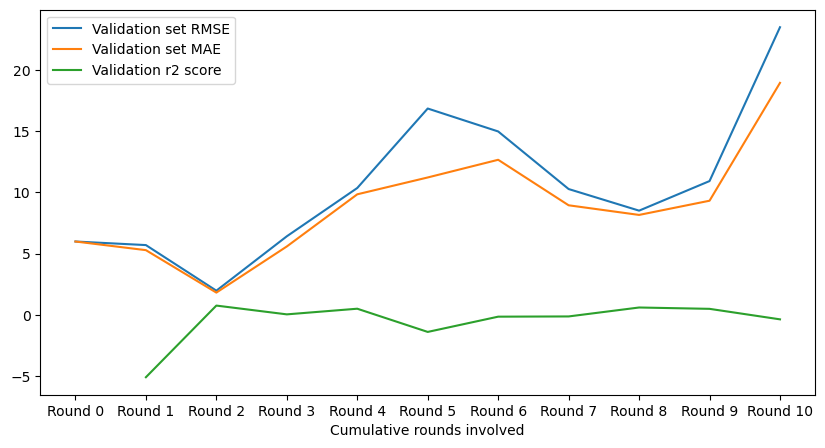

In [57]:
round_nb = [f'Round {i}' for i in range(0,11)]
plt.figure(figsize=(10,5))
plt.plot(round_nb, total_list('validation RMSE'), label='Validation set RMSE')
plt.plot(round_nb, total_list('validation MAE'), label='Validation set MAE')
plt.plot(round_nb, total_list('validation r2 score'), label = ('Validation r2 score'))
plt.xlabel('Cumulative rounds involved')
plt.legend()

The r2 score has a smaller variance after Round 5.

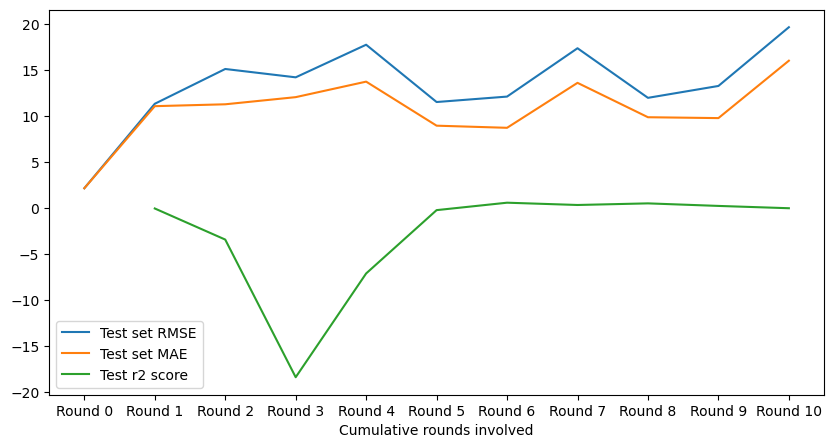

In [58]:

plt.figure(figsize=(10,5))
plt.plot(round_nb, total_list('test RMSE'), label='Test set RMSE')
plt.plot(round_nb, total_list('test MAE'), label='Test set MAE')
plt.plot(round_nb, total_list('test r2 score'), label = ('Test r2 score'))
plt.xlabel('Cumulative rounds involved')
plt.legend()

After the addition of the fifth round, it seems the accuracy starts to converge.

All of the accuracies are very poor. There isn't enough data to produce satisfying results.

## SHAP explanations

In [84]:
def shap_dicts(shap_values):
    pos_shaps_dict = {}
    neg_shaps_dict = {}
    for j in x_00.columns:
        feature_shaps_pos = [shap_values.values[i][x_00.columns.to_list().index(j)] for i in range(0,len(shap_values.values)) if shap_values.data[i][x_00.columns.to_list().index(j)] == 1]
        pos_shaps_dict[j]= np.mean(feature_shaps_pos)
        feature_shaps_neg = [shap_values.values[i][x_00.columns.to_list().index(j)] for i in range(0,len(shap_values.values)) if shap_values.data[i][x_00.columns.to_list().index(j)] == 0]
        neg_shaps_dict[j] = np.mean(feature_shaps_neg)
    tot_shaps_dict = {}
    for i in pos_shaps_dict.keys():
        tot_shaps_dict[i] = abs(pos_shaps_dict[i]) + abs(neg_shaps_dict[i])
    return pos_shaps_dict, neg_shaps_dict, tot_shaps_dict

In [85]:
def max_dict(dictio):
    return list(dictio.keys())[list(dictio.values()).index(max(dictio.values()))]
def min_dict(dictio):
    return list(dictio.keys())[list(dictio.values()).index(min(dictio.values()))]

In [88]:
pos_shap_00, neg_shap_00, tot_shap_00 = shap_dicts(shap_00)
pos_shap_01, neg_shap_01, tot_shap_01 = shap_dicts(shap_01)
pos_shap_02, neg_shap_02, tot_shap_02 = shap_dicts(shap_02)
pos_shap_03, neg_shap_03, tot_shap_03 = shap_dicts(shap_03)
pos_shap_04, neg_shap_04, tot_shap_04 = shap_dicts(shap_04)
pos_shap_05, neg_shap_05, tot_shap_05 = shap_dicts(shap_05)
pos_shap_06, neg_shap_06, tot_shap_06 = shap_dicts(shap_06)
pos_shap_07, neg_shap_07, tot_shap_07 = shap_dicts(shap_07)
pos_shap_08, neg_shap_08, tot_shap_08 = shap_dicts(shap_08)
pos_shap_09, neg_shap_09, tot_shap_09 = shap_dicts(shap_09)
pos_shap_10, neg_shap_10, tot_shap_10 = shap_dicts(shap_10)

Mean of empty slice.
invalid value encountered in scalar divide


In [93]:
max_shaps = pandas.DataFrame([[0, max_dict(pos_shap_00),min_dict(neg_shap_00), max_dict(neg_shap_00), min_dict(pos_shap_00), max_dict(tot_shap_00)],
[1, max_dict(pos_shap_01),min_dict(neg_shap_01), max_dict(neg_shap_01), min_dict(pos_shap_01), max_dict(tot_shap_01)],
[2, max_dict(pos_shap_02),min_dict(neg_shap_02), max_dict(neg_shap_02), min_dict(pos_shap_02), max_dict(tot_shap_02)],
[3, max_dict(pos_shap_03),min_dict(neg_shap_03), max_dict(neg_shap_03), min_dict(pos_shap_03), max_dict(tot_shap_03)],
[4, max_dict(pos_shap_04),min_dict(neg_shap_04), max_dict(neg_shap_04), min_dict(pos_shap_04), max_dict(tot_shap_04)],
[5, max_dict(pos_shap_05),min_dict(neg_shap_05), max_dict(neg_shap_05), min_dict(pos_shap_05), max_dict(tot_shap_05)],
[6, max_dict(pos_shap_06),min_dict(neg_shap_06), max_dict(neg_shap_06), min_dict(pos_shap_06), max_dict(tot_shap_06)],
[7, max_dict(pos_shap_07),min_dict(neg_shap_07), max_dict(neg_shap_07), min_dict(pos_shap_07), max_dict(tot_shap_07)],
[8, max_dict(pos_shap_08),min_dict(neg_shap_08), max_dict(neg_shap_08), min_dict(pos_shap_08), max_dict(tot_shap_08)],
[9, max_dict(pos_shap_09),min_dict(neg_shap_09), max_dict(neg_shap_09), min_dict(pos_shap_09), max_dict(tot_shap_09)],
[10, max_dict(pos_shap_10),min_dict(neg_shap_10), max_dict(neg_shap_10), min_dict(pos_shap_10), max_dict(tot_shap_10)]])
max_shaps.columns = ['Rounds (cumulative)', 'Highest positive impact (present)', 'Highest negative impact (absent)', 'Highest positive impact (absent)', 'Highest negative impact (present)', 'Overall most influencial feature']
max_shaps


,Rounds (cumulative),Highest positive impact (present),Highest negative impact (absent),Highest positive impact (absent),Highest negative impact (present),Overall most influencial feature
0,0,Cu(OAc)2,EtOH,60,Cu(OAc)2,Cu(OAc)2
1,1,80,TBAO,60,1.1,1.5
2,2,TBAO,TBAO,1.1,L3,TBAO
3,3,Cu(OAc)2,TBAO,80,Cu(OAc)2,Cu(OAc)2
4,4,Cu(OAc)2,0.5,80,Cu(OAc)2,Cu(OAc)2
5,5,Cu(OAc)2,TBAO,CuCl,Cu(OAc)2,Cu(OAc)2
6,6,K2CO3,TBAO,1.1,KOH,KOH
7,7,K2CO3,TBAO,L5,2Me-THF,K2CO3
8,8,Cu(OAc)2,K2CO3,0.05,Cu(OAc)2,Cu(OAc)2
9,9,L7,K2CO3,0.05,PhMe,L7


In [101]:
pos_shaps_dict = {"0": pos_shap_00,"1": pos_shap_01,"2": pos_shap_02,"3": pos_shap_03,"4": pos_shap_04,"5": pos_shap_05,"6": pos_shap_06,"7": pos_shap_07,
"8": pos_shap_08,"9": pos_shap_09,"10": pos_shap_10}
neg_shaps_dict = {"0": neg_shap_00,"1": neg_shap_01,"2": neg_shap_02,"3": neg_shap_03,"4": neg_shap_04,"5": neg_shap_05,"6": neg_shap_06,"7": neg_shap_07,
"8": neg_shap_08,"9": neg_shap_09,"10": neg_shap_10}

In [120]:
def find_best(nb):
    """
    finds the best combinations via SHAP
    """
    rxns_df = pandas.read_csv("godineau2023_reactions_with_yields.tsv",sep='\t' )

    base_shaps_dict = {i : pos_shaps_dict[f'{nb}'][i] for i in rxns_df["Base"]}
    solv_shaps_dict = {i : pos_shaps_dict[f'{nb}'][i] for i in rxns_df["Solvent"]}
    cu_shaps_dict = {i : pos_shaps_dict[f'{nb}'][i] for i in rxns_df["Cu source"]}
    ligand_shaps_dict = {i : pos_shaps_dict[f'{nb}'][i] for i in rxns_df["Ligand"]}
    lig_eq = [str(i) for i in rxns_df['Ligand equiv.']]
    ligeq_shaps_dict = {i : pos_shaps_dict[f'{nb}'][i] for i in lig_eq}
    mol_list = [f'{i} M' for i in rxns_df['Molarity']]
    mol_shaps_dict = {i : pos_shaps_dict[f'{nb}'][i] for i in mol_list}
    baseq = [str(i) for i in rxns_df['Base equiv.']]
    baseq_shaps_dict = {i : pos_shaps_dict[f'{nb}'][i] for i in baseq}
    bnnh2 = [str(i) for i in rxns_df['BnNH2 equiv.']]
    bnnh2_shaps_dict = {i : pos_shaps_dict[f'{nb}'][i] for i in bnnh2}
    temp = [str(i) for i in rxns_df["T [°C]"]]
    temp_shaps_dict = {i : pos_shaps_dict[f'{nb}'][i] for i in temp}

    base_shaps_dict1 = {i : neg_shaps_dict[f'{nb}'][i] for i in rxns_df["Base"]}
    solv_shaps_dict1 = {i : neg_shaps_dict[f'{nb}'][i] for i in rxns_df["Solvent"]}
    cu_shaps_dict1 = {i : neg_shaps_dict[f'{nb}'][i] for i in rxns_df["Cu source"]}
    ligand_shaps_dict1 = {i : neg_shaps_dict[f'{nb}'][i] for i in rxns_df["Ligand"]}
    lig_eq1 = [str(i) for i in rxns_df['Ligand equiv.']]
    ligeq_shaps_dict1 = {i : neg_shaps_dict[f'{nb}'][i] for i in lig_eq1}
    mol_list1 = [f'{i} M' for i in rxns_df['Molarity']]
    mol_shaps_dict1 = {i : neg_shaps_dict[f'{nb}'][i] for i in mol_list1}
    baseq1 = [str(i) for i in rxns_df['Base equiv.']]
    baseq_shaps_dict1 = {i : neg_shaps_dict[f'{nb}'][i] for i in baseq1}
    bnnh21 = [str(i) for i in rxns_df['BnNH2 equiv.']]
    bnnh2_shaps_dict1 = {i : neg_shaps_dict[f'{nb}'][i] for i in bnnh21}
    temp1 = [str(i) for i in rxns_df["T [°C]"]]
    temp_shaps_dict1 = {i : neg_shaps_dict[f'{nb}'][i] for i in temp1}


    print(f'According to all the rounds up to Round {nb}, the best combination is :')
    print(f'Base : {max_dict(base_shaps_dict) if max(base_shaps_dict.values()) > abs(min(base_shaps_dict1.values())) else min_dict(base_shaps_dict1)}')
    print(f'Solvent : {max_dict(solv_shaps_dict) if max(solv_shaps_dict.values()) > abs(min(solv_shaps_dict1.values())) else min_dict(solv_shaps_dict1)}')
    print(f'Cu source : {max_dict(cu_shaps_dict) if max(cu_shaps_dict.values()) > abs(min(cu_shaps_dict1.values())) else min_dict(cu_shaps_dict1)}')
    print(f'Ligand : {max_dict(ligand_shaps_dict) if max(ligand_shaps_dict.values()) > abs(min(ligand_shaps_dict1.values())) else min_dict(ligand_shaps_dict1)}')
    print(f'Ligand equivalent : {max_dict(ligeq_shaps_dict) if max(ligeq_shaps_dict.values()) > abs(min(ligeq_shaps_dict1.values())) else min_dict(ligeq_shaps_dict1)}')
    print(f'Molarity : {max_dict(mol_shaps_dict) if max(mol_shaps_dict.values()) > abs(min(mol_shaps_dict1.values())) else min_dict(mol_shaps_dict1)}')
    print(f'Base equivalent : {max_dict(baseq_shaps_dict) if max(baseq_shaps_dict.values()) > abs(min(baseq_shaps_dict1.values())) else min_dict(baseq_shaps_dict1)}')
    print(f'BnNH2 equivalent : {max_dict(bnnh2_shaps_dict) if max(bnnh2_shaps_dict.values()) > abs(min(bnnh2_shaps_dict1.values())) else min_dict(bnnh2_shaps_dict1)}')
    print(f'Temperature : {max_dict(temp_shaps_dict) if max(temp_shaps_dict.values()) > abs(min(temp_shaps_dict1.values())) else min_dict(temp_shaps_dict1)}')

In [123]:
for i in range(0,11):
    find_best(i)
    print('-----------------------------------------')

According to all the rounds up to Round 0, the best combination is :
Base : TBAO
Solvent : EtOH
Cu source : Cu(OAc)2
Ligand : L5
Ligand equivalent : 0.05
Molarity : 0.5 M
Base equivalent : 2.0
BnNH2 equivalent : 1.5
Temperature : 60
-----------------------------------------
According to all the rounds up to Round 1, the best combination is :
Base : TBAO
Solvent : EtOH
Cu source : Cu2O
Ligand : L3
Ligand equivalent : 0.05
Molarity : 0.5 M
Base equivalent : 2.0
BnNH2 equivalent : 1.5
Temperature : 60
-----------------------------------------
According to all the rounds up to Round 2, the best combination is :
Base : TBAO
Solvent : EtOH
Cu source : Cu2O
Ligand : L5
Ligand equivalent : 0.05
Molarity : 1.0 M
Base equivalent : 0.5
BnNH2 equivalent : 1.5
Temperature : 60
-----------------------------------------
According to all the rounds up to Round 3, the best combination is :
Base : TBAO
Solvent : EtOH
Cu source : CuI
Ligand : L4
Ligand equivalent : 0.05
Molarity : 1.0 M
Base equivalent :

According to all the rounds up to Round 5, the best combination is :
Base : TBAO
Solvent : EtOH
Cu source : Cu2O
Ligand : L4
Ligand equivalent : 0.1
Molarity : 1.0 M
Base equivalent : 0.5
BnNH2 equivalent : 1.5
Temperature : 60
-----------------------------------------
According to all the rounds up to Round 6, the best combination is :
Base : K2CO3
Solvent : EtOH
Cu source : Cu2O
Ligand : L9
Ligand equivalent : 0.1
Molarity : 1.0 M
Base equivalent : 0.5
BnNH2 equivalent : 1.5
Temperature : 80
-----------------------------------------
According to all the rounds up to Round 7, the best combination is :
Base : K2CO3
Solvent : EtOH
Cu source : Cu2O
Ligand : L9
Ligand equivalent : 0.1
Molarity : 1.0 M
Base equivalent : 0.5
BnNH2 equivalent : 1.5
Temperature : 80
-----------------------------------------
According to all the rounds up to Round 8, the best combination is :
Base : K2CO3
Solvent : EtOH
Cu source : CuBr
Ligand : L7
Ligand equivalent : 0.1
Molarity : 1.0 M
Base equivalent : 0.5